# Méthodo 

## **Algorithm:**

1. Metadata elimination
    1. EDA to select 
    2. Meta data ... 
    Note : probablement OFF 
2. Encodings in DB of all images( using CNN ) 
    1. AE
    2. NN 
3. Compute Similarity Function
    1. Cosine ?? 
    2. Fisher vetor ?? 
4. Create graph (edges : images, nodes : similarity)
5. Apply Pagerank 

## Template Matching

- Template and query image
- Hypernetworks
- Padd network
- Create multiple patches data

In [1893]:
from pathlib import Path, PurePath
from typing import Dict, List, Optional, Union
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from imagededup.utils.data_generator import DataGenerator

import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications import MobileNetV2
from keras.models import Model
from IPython.display import Image

from keras import backend as K
from keras.layers import Dense, Activation,Conv2D, MaxPool2D, Flatten, Input, ZeroPadding2D
from keras.layers.merge import concatenate
from keras.utils import plot_model


from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import models
from keras.applications import imagenet_utils
from keras import metrics


from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


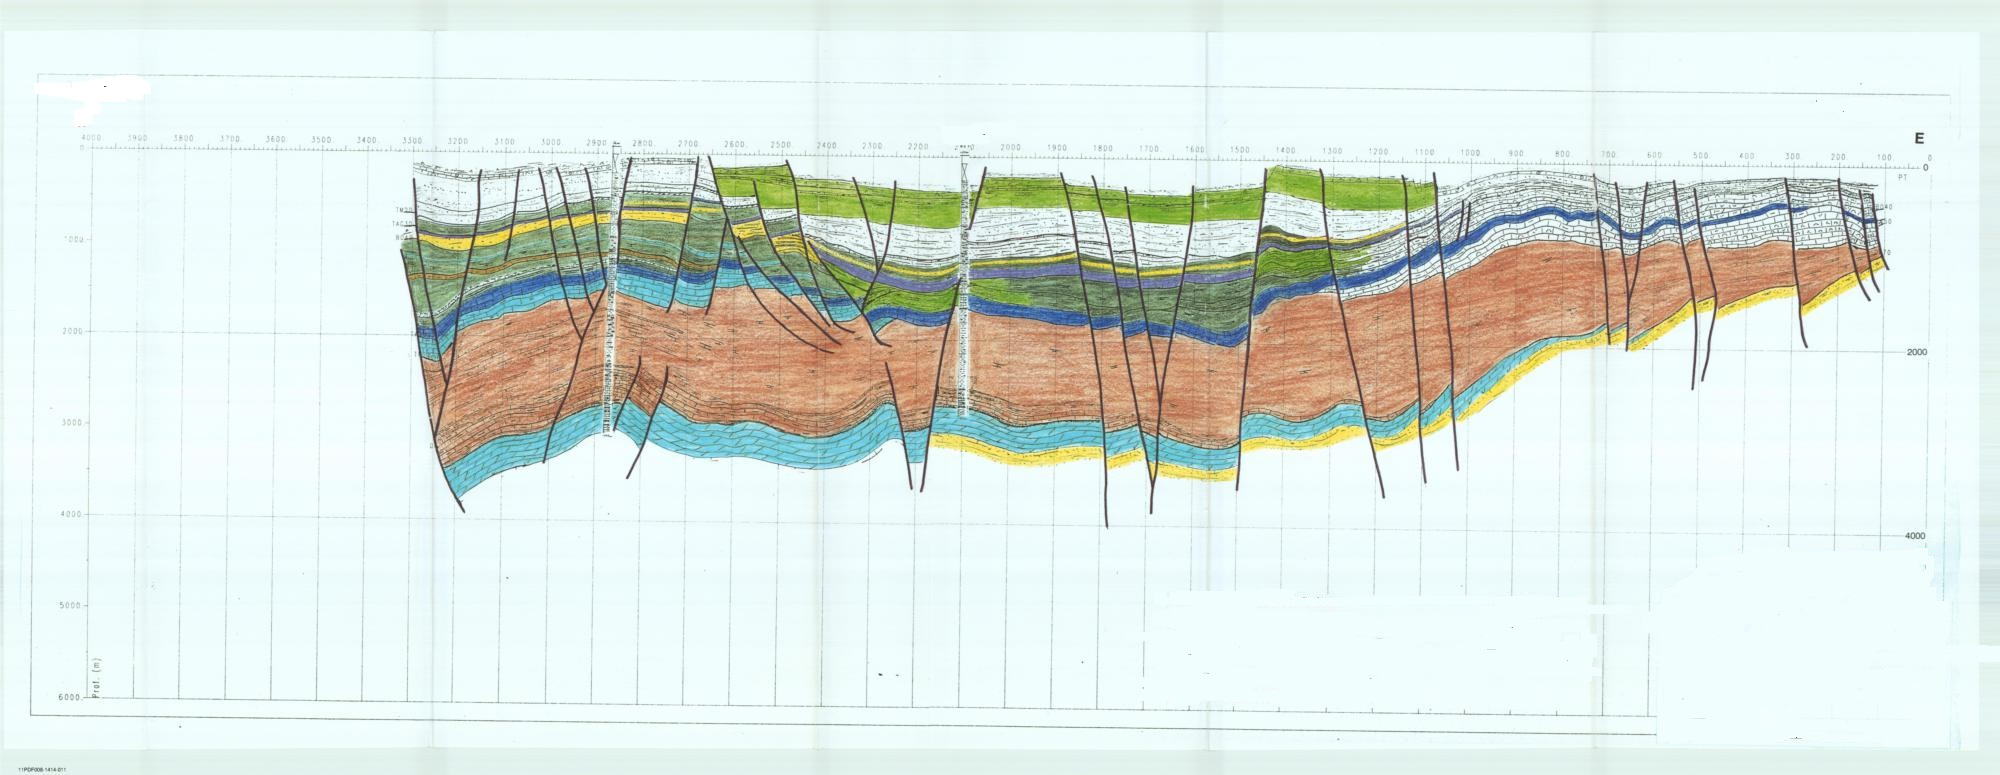

In [1894]:
test_image_path='../datasets/near_duplicates/00132.jpg'

# image vis

Image(filename=test_image_path)

In [1895]:
def prepare_image(path):
    img = load_img(path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array_expanded_dims =np.array([img_array]) 
    return preprocess_input(img_array_expanded_dims)


In [1896]:
base_model= MobileNet(weights='imagenet',include_top=False,pooling='avg') 
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 

In [1897]:
image_model = prepare_image(test_image_path)
pred = base_model.predict(image_model)
pred_vec = pred.flatten()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## k -mean after encoding

In [1898]:
# Encod directory 

In [1899]:
import os 
dir_path ='../datasets/near_duplicates/'

In [1900]:
# BATch optim
def encoding_directory(dir_path):
    '''
    Returns a dict { filename, encoding} 
    '''    
    encoding_map ={}
    filenames = [dir for dir in os.listdir(dir_path)]
    for image_path in filenames : 
        image_model = prepare_image(dir_path+image_path)    
        pred = base_model.predict(image_model)
        pred_vec = pred.flatten()
        encoding_map[image_path] = pred_vec
    return encoding_map
    

In [1901]:
import pickle
filename ="output.pickle"
file_to_write = open(filename, "wb")
pickle.dump(encoding, file_to_write)
file_to_write.close()


## Apply k-means

In [1902]:
import pandas as pd

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6)

In [1960]:
infile = open('output.pickle','rb')
new_dict = pickle.load(infile, encoding='bytes')

In [1965]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,cluster
00001.jpg,0.188682,0.600168,0.716883,0.848890,0.204397,0.276359,1.335617,0.068772,0.021662,1.172873,...,0.169446,0.041333,0.0,0.444132,2.270193,0.000000,0.201849,0.000000,0.053099,4
00002.jpg,0.188443,0.595225,0.719540,0.843764,0.204123,0.273712,1.336512,0.068828,0.019736,1.173808,...,0.169979,0.039584,0.0,0.443217,2.270604,0.000000,0.202749,0.000000,0.053298,4
00003.jpg,0.022087,1.566435,0.530465,1.189206,0.274682,0.274583,0.354840,0.856791,0.733379,0.553497,...,0.469846,0.000000,0.0,0.022789,2.533936,1.031695,0.531112,0.002795,0.169643,4
00004.jpg,0.000000,0.295583,0.196082,1.052166,0.362730,0.131844,0.000000,3.537106,0.000000,0.000000,...,2.362841,0.022472,0.0,1.846433,0.403647,2.075427,2.423167,0.000000,0.079690,2
00005.jpg,0.027293,0.626000,0.815290,1.462259,0.327261,0.038388,0.454559,0.837441,0.452637,0.687069,...,0.011182,0.000000,0.0,0.401429,2.172801,0.503749,0.048647,0.000000,0.289743,4


In [1978]:
kmeans.fit(df.iloc[:,:-1])

KMeans(n_clusters=6)

In [1979]:
df['cluster'] =kmeans.labels_

In [1980]:
df.to_csv('encoding_images_cluster.csv')

# Direct similarity on cluster

In [2001]:
PATH ='00076.jpg'
DIRECTORY ='../datasets/near_duplicates/'
test_image_path=DIRECTORY+PATH

Image la plus similaire dans le répertoire :
('00107.jpg', 0.999096112190099)


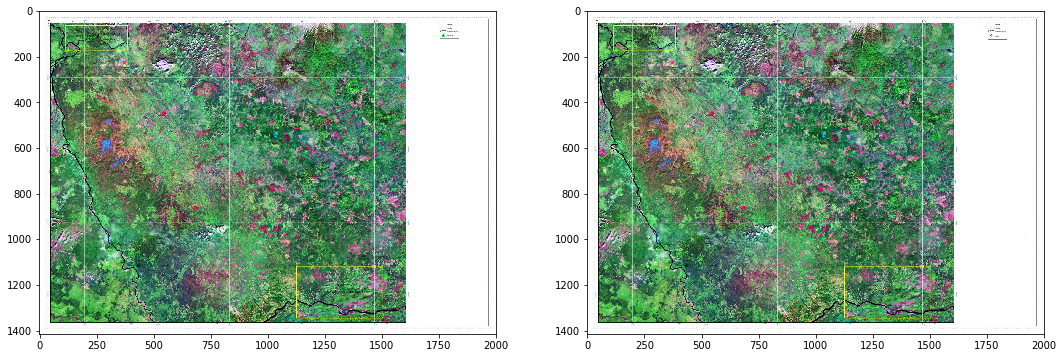

In [2002]:
from utils import similarities, image_read
S = similarities(kmeans,PATH,df)
print('Image la plus similaire dans le répertoire :')
print(S[0])
sim_image_path='../datasets/near_duplicates/'+S[0][0]
# image vis
image =image_read(DIRECTORY+PATH)
image_sim = image_read(sim_image_path)

fig, ax = plt.subplots(1,2,figsize=(18, 10))
ax[0].imshow(image)
ax[1].imshow(image_sim)

In [ ]:
for sim, _  in S :
    image = image_read(DIRECTORY+image_path)
    print("Image size", image.shape)
    ax[0].figure(figsize=(20,20))
    ax[1].imshow(image)
    
    
fig, ax = plt.subplots(1,2,figsize=(18, 10))
ax[0].imshow(cropped_dict[PATH][n])
ax[1].imshow(prepare_image(DIRECTORY+PATH)[0])

# Evaluation

In [ ]:
# Similar pairs
pairs={}
for path in df.index:
    sim = similarities(path,df,nb_similar=10)
    dum =[name for name , score in sim if score >0.8]
    pairs[path] = dum   

In [ ]:
# from imagededup.methods import PHash
# plot duplicates obtained for a given file using the duplicates dictionary
from imagededup.utils import plot_duplicates

phasher = PHash()

# Generate encodings for all images in an image directory
encodings = phasher.encode_images(image_dir=DIRECTORY)

# Find duplicates using the generated encodings
duplicates = phasher.find_duplicates(encoding_map=encodings)

In [ ]:
# MATCHING by list
diff ={}
for im in pairs.keys() :
    if len(pairs[im]) > 0 and len(duplicates[im]) > 0:
        matches = set(pairs[im])&set(duplicates[im])
        if len(set(pairs[im])&set(duplicates[im])) == 0: 
            diff[im]=(pairs[im],duplicates[im])            
            

In [ ]:
diff

In [ ]:
# MATCHING by first
diff ={}
for im in pairs.keys() :
    if len(pairs[im]) > 0 and len(duplicates[im]) > 0:
        if pairs[im][0] != duplicates[im][0] : 
            diff[im]=(pairs[im],duplicates[im])            
            

# PARTIE II : Template Matching

In [ ]:
## Model 

In [ ]:
base_model= MobileNetV2(weights='imagenet',include_top=False) 
base_model.trainable = False

inp1 = Input(shape=(224,224,3))
x1 = base_model(inp1)
inp2 = Input(shape=(224,224,3))
# Add paddinf
x2 = base_model(inp2)
x = concatenate([x1, x2])
# add layers
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) 
x=Dense(1024,activation='relu')(x) 
x=Dense(512,activation='relu')(x) 
output =Dense(1, activation='sigmoid')(x) #final layer with binaru activation

In [ ]:
model = Model([inp1,inp2],output)

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='Adam',loss='binary_crossentropy',
              metrics=[metrics.BinaryCrossentropy(),metrics.AUC()])

## Prepare cropped data

In [1910]:
from utils import generate_data, generate_duplicate_list, prepare_template_image, template_matching

### Generate Labeled dataset

In [ ]:
cropped_dict = generate_duplicate_list(DIRECTORY)

In [ ]:
cropped_dictame ="cropped_dict"
file_to_write = open(filename, "wb")
pickle.dump(cropped_dict, file_to_write)
file_to_write.close()

In [ ]:
# Exemple of cropping
PATH =list(cropped_dict.keys())[np.random.randint(0,len(cropped_dict.keys()))]
n = np.random.randint(0,10)
fig, ax = plt.subplots(1,2,figsize=(18, 10))
ax[0].imshow(cropped_dict[PATH][n])
ax[1].imshow(prepare_image(DIRECTORY+PATH)[0])

In [ ]:
# Create pairs with labels in form [in1,in2], Label

In [ ]:
X, y = generate_data(cropped_dict)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(18, 10))
n = np.random.randint(0,X[0].shape[0])
ax[0].imshow(X[0][n])
ax[1].imshow(X[1][n])
print(y[n])

In [ ]:
history  = model.fit(X,y,epochs =10,batch_size=32)

In [ ]:
import matplotlib.pyplot as plt 

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Evaluation 

In [1940]:
IMAGESDIR = '../datasets/template_matching/'
QUERY_PATH= 'image_9.png'
TEMPLATE_PATH =  'image_9_template_1.png'
query_image_path = os.path.join(IMAGESDIR, 'original', QUERY_PATH)
template_image_path = os.path.join(IMAGESDIR, 'template', TEMPLATE_PATH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction score : [[0.98554903]]


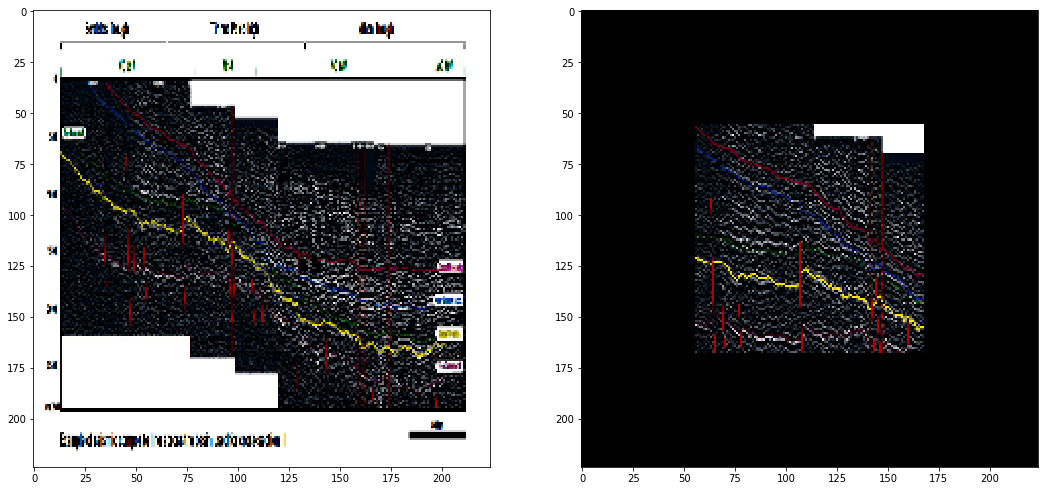

In [1941]:
template_matching(query_image_path,template_image_path,model)                  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction score : [[0.00946425]]


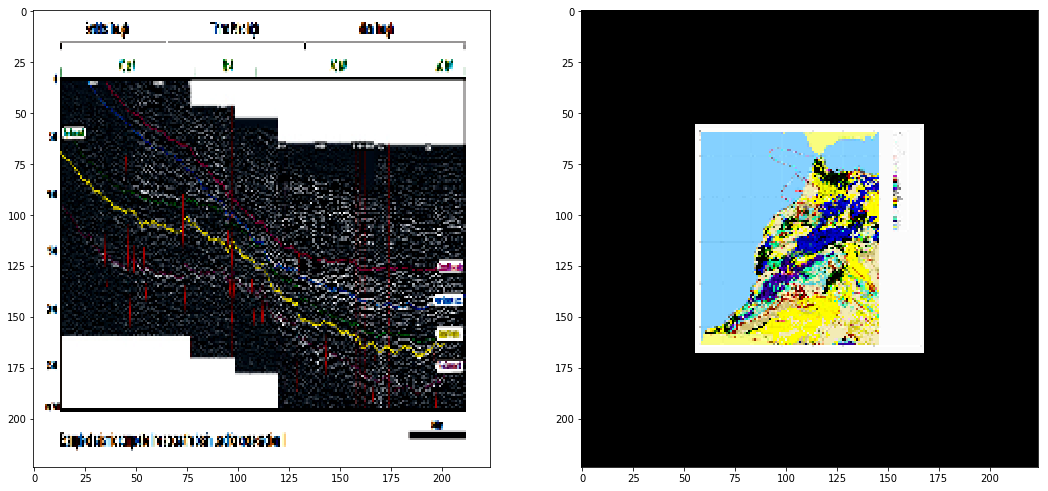

In [1936]:
QUERY_PATH= 'image_9.png'
TEMPLATE_PATH =  'image_1_template_1.jpg'
query_image_path = os.path.join(IMAGESDIR, 'original', QUERY_PATH)
template_image_path = os.path.join(IMAGESDIR, 'template', TEMPLATE_PATH)
template_matching(query_image_path,template_image_path,model)